In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from xailib.data_loaders.dataframe_loader import prepare_dataframe

from xailib.explainers.lime_explainer import LimeXAITabularExplainer
from xailib.explainers.lore_explainer import LoreTabularExplainer
from xailib.explainers.shap_explainer_tab import ShapXAITabularExplainer

from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper

In [2]:
import altair as alt
from IPython.display import HTML

### Load the dataset and prepare it

In [2]:
source_file = 'datasets/german_credit.csv'
class_field = 'default'
# Load and transform dataset 
df = pd.read_csv(source_file, skipinitialspace=True, na_values='?', keep_default_na=True)

In [3]:
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = prepare_dataframe(df, class_field)

### Split the dataset into train and test and scale it

In [4]:
test_size = 0.3
random_state = 42
X_train, X_test, Y_train, Y_test = train_test_split(df[feature_names], df[class_field],
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=df[class_field])



### Define and train a logistic regression model

In [5]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

bb = LogisticRegression(C=1, penalty='l2')
bb.fit(X_scaled, Y_train.values)
# pass the model to the wrapper to use it in the XAI lib
bbox = sklearn_classifier_wrapper(bb)

In [6]:
# select a record to explain
inst = X_train.iloc[182].values
print('Instance ',inst[0:10])
print('True class ',Y_train.iloc[18])
print('Predicted class ',bb.predict(inst.reshape(1, -1)))

Instance  [   48 12169     4     4    36     1     1     1     0     0]
True class  1
Predicted class  [1]


### SHAP explainer
##### We first define the explainer method we want to use: SHAP. It produces feature importance. Then, we can define a dictionary containing the SHAP's parameters we want. 
##### Explainer can be: linear, tree, kernel, deep
##### X_train is the training set we want the explainer to train on. It can be all the training set used for the training of the target model, just a piece of it or we can apply a clustering algorithm on it. 

In [112]:
explainer = ShapXAITabularExplainer(bbox, feature_names)
config = {'explainer' : 'linear', 'X_train' : X_train.iloc[0:100].values, 'feature_pert' : 'interventional'}
explainer.fit(config)

#### We explain the instance and obtain the SHAP values

In [113]:
print('building an explanation')
exp = explainer.explain(inst)
print(exp)

building an explanation


##### We can use the method plot_shap_values to get a visual representation. 
##### Parameters: feature_names, the list of features, exp, the explanation we want to plot, start and end, which denotes the range of features we want to plot

In [114]:
exp.plot_features_importance()

alt.VConcatChart(...)

### LORE explainer
##### We first define the explainer method we want to use: LORE. It produces rules and counterfactual rules. We can define a dictionary containing the LORE's parameters we want. 
##### neigh_type can be: random, genetic, rndgen, geneticp, rndgenp

In [10]:
explainer = LoreTabularExplainer(bbox)
config = {'neigh_type':'geneticp', 'size':1000, 'ocr':0.1, 'ngen':10}
explainer.fit(df, class_field, config)
exp = explainer.explain(inst)
print(exp)

r = { age <= 20.73, credit_amount > -439.64, purpose=retraining <= 0.12, duration_in_month > -1.94, purpose=furniture/equipment <= 0.18, foreign_worker=no <= 0.72, purpose=domestic appliances <= 1.02, savings=.. >= 1000 DM  <= 0.72, purpose=(vacation - does not exist?) <= 0.46, credit_history=critical account/ other credits existing (not at this bank) <= 0.91, people_under_maintenance <= -0.01 } --> { default: 1 }
c = { { credit_amount <= -439.64 },
      { age > 20.73 } }


In [12]:
from externals.lore.lore.explanation import ExplanationEncoder
import json
expData=json.loads(json.dumps(exp, cls=ExplanationEncoder))
expData

{'bb_pred': 1,
 'dt_pred': 1,
 'rule': {'premise': [{'att': 'credit_amount',
    'op': '>',
    'thr': 8.5,
    'is_continuous': True}],
  'cons': 1,
  'class_name': 'default'},
 'crules': [],
 'deltas': [],
 'fidelity': 0.9991348371172663,
 'dt': [True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  True,
  False,
  True,
  True,
  False,
  False,
  False,
  True,
  True,
  False,
  True,
  True,
  True,
  False,
  False,
  True,
  True,
  False,
  True,
  True,
  False,
  True,
  False,
  True,
  True,
  False,
  True,
  True,
  False,
  True,
  True,
  False,
  False,
  False,
  True,
  True,
  False,
  False,
  True,
  False,
  True,
  False,
  True,
  True,
  False,
  False,
  False,
  False,
  True,
  False,
  True,
  True,
  True,
  False,
  False,
  True,
  False,
  False,
  True,
  True,
  False,
  True,
  True,
  True,
  False,
  False,
  False,
  True,
  False,
  True,
  True,
  True,
  False,
  

#### viz rules

In [13]:
def plot_rules(expData):
    htmlStyle=HTML("""
            <style>
            .red {
              background-color:firebrick;
              padding:3px 5px 3px 5px;
              border-radius:5px;

              color:white;
            }
            .rules{
                margin-top:10px;
                font-weight: 400;
            }
            .rule{
              padding:5px 20px 5px 20px;
              border-radius:5px;
              margin-right:5px;
              font-size:12px;
              line-height:20px;
              display: block;
              margin-bottom: 10px;
              width: fit-content;
              
              color:white;
              background-color:firebrick;
              opacity:0.8;
            }
            </style>
            """
            )

    htmlPrediction=HTML(
        '''
        <h3>Why the predicted value for class <span class='red'>%s</span> is <span class='red'>%s</span> ?</h3>
        '''%(expData['rule']['class_name'],expData['rule']['cons'])
    )

    htmlExplanation=HTML('''
        <p>Because all the following conditions happen:</p>
        ''')


    rulesSpans=""
    for el in expData['rule']['premise']:
        rulesSpans+="<span class='rule'>"+el['att'].replace("_"," ")+ " <strong>" + el['op']+ "</strong> "+ str(el['thr'])+"</span>"

    htmlRules=HTML("<p class='rules'>%s</p>"%(rulesSpans))

    display(htmlStyle)
    display(htmlPrediction)
    display(htmlExplanation)
    display(htmlRules)

In [14]:
plot_rules(expData)

In [15]:
def plot_crules(expData):
    htmlStyle=HTML("""
            <style>
            .red {
              background-color:firebrick;
              padding:3px 5px 3px 5px;
              border-radius:5px;
              color:white;
            }
            .crules{
                margin-top:10px;
                font-weight: 400;
            }
            .crule{            
              padding:5px 20px 5px 20px;
              border-radius:5px;
              margin-right:5px;
              font-size:12px;
              line-height:20px;
              display: block;
              margin-bottom: 10px;
              width: fit-content;
              
              color:#202020;
              background-color:gold;
            }
            </style>
            """
            )
    display(htmlStyle)

    htmlTitleCRules=HTML('''
        <h3>The predicted value for class <span class='red'>%s</span> would have been:</h3>
        '''%(expData['rule']['class_name'])
                       )

    display(htmlTitleCRules)
    
    cRulesDiv=''
    for idx,el in enumerate(expData['crules']):
        cRulesTitle= el['cons']
        cRulesSpans=""
        for p in el['premise']:
            cRulesSpans+="<span class='crule'>"+p['att'].replace("_"," ")+ " " + p['op']+ " "+ str(p['thr'])+"</span>"

            
        display(HTML('''
            <div class='crules'>
                <div>
                    <h4><span class='red'>%s</span> if the following condition holds</h4>
                </br>%s
                </div>
            </div>
        '''%(cRulesTitle,cRulesSpans))   
        )
    

In [16]:
plot_crules(expData)

### LIME explainer
##### We first define the explainer method we want to use: LIME. It produces feature importances. We can define a dictionary containing the LIME's parameters we want. 
##### There are several parameters we can define: feature selection, discretize continuous, discretizer, sample_around_instance, kernel width, kernel.

In [12]:
limeExplainer = LimeXAITabularExplainer(bbox)
config = {'feature_selection': 'lasso_path'}
limeExplainer.fit(df, class_field, config)
lime_exp = limeExplainer.explain(inst)
print(lime_exp.as_list())

[('credit_amount', 0.1845654316597168), ('credit_history=all credits at this bank paid back duly', -0.019668550694834613), ('credits_this_bank', 0.019489762179761182), ('people_under_maintenance', -0.01793506324614226), ('account_check_status=0 <= ... < 200 DM', -0.017627655025522004), ('purpose=(vacation - does not exist?)', 0.015378801933473928), ('foreign_worker=yes', -0.014504088125337407), ('savings=... < 100 DM', 0.013889072278937176), ('other_debtors=co-applicant', -0.012369104193528359), ('property=unknown / no property', -0.012246619840214997)]


##### To plot the explanation, we pass the explanation as a list (tuples, where the first element is the feature name and the second the actual feature importance), start and end of the range of features we want to visualize.

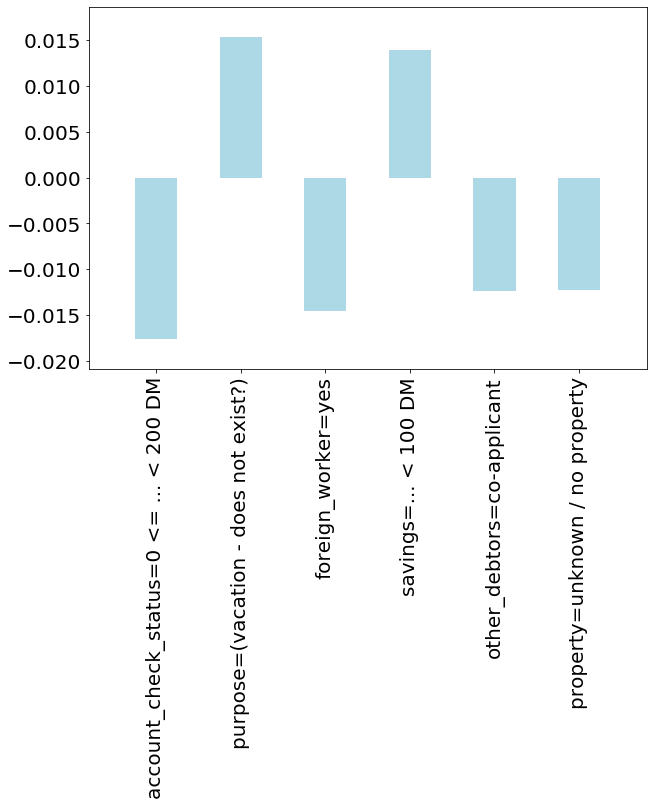

In [13]:
limeExplainer.plot_lime_values(lime_exp.as_list(), 4, 15)

### Define and train a RFClassifier

In [14]:
bb = RandomForestClassifier(n_estimators=20, random_state=random_state)
bb.fit(X_train.values, Y_train.values)
bbox = sklearn_classifier_wrapper(bb)   

In [15]:
explainer = ShapXAITabularExplainer(bbox, feature_names)
config = {'explainer' : 'kernel', 'X_train' : X_train.iloc[0:100].values}
explainer.fit(config)

In [16]:
inst = X_train.iloc[147].values
print('Instance ',inst[0:10])
print('True class ',Y_train.iloc[8])
print('Predicted class ',bb.predict(inst.reshape(1, -1)))

Instance  [ 15 975   2   3  25   2   1   0   1   0]
True class  0
Predicted class  [0]


In [17]:
print('building an explanation')
exp = explainer.explain(inst)
print(exp.exp)

building an explanation
[array([ 0.04715923,  0.0022611 ,  0.02798255,  0.00055699,  0.03167227,
        0.        ,  0.        ,  0.01891519, -0.0221272 ,  0.        ,
       -0.02722098,  0.00020394,  0.06116851,  0.        ,  0.00486966,
        0.00360085,  0.00111547,  0.        ,  0.01245122,  0.        ,
        0.        ,  0.        ,  0.        , -0.01166775,  0.00408231,
        0.        ,  0.00228749,  0.00133754,  0.00246972,  0.        ,
        0.        ,  0.00687302,  0.01439376,  0.01346266,  0.00011814,
        0.00299125,  0.00129715,  0.01399078,  0.00145797,  0.00690912,
        0.00292826,  0.        ,  0.00090033,  0.0268793 ,  0.        ,
       -0.011827  ,  0.00630118,  0.01383862,  0.01139758,  0.00365956,
        0.        ,  0.01873748,  0.00141803,  0.00089606,  0.        ,
        0.00470249,  0.        ,  0.        ,  0.00905615,  0.        ,
        0.        ]), array([-0.04715923, -0.0022611 , -0.02798255, -0.00055699, -0.03167227,
        0.       

In [18]:
exp.plot_features_importance()

alt.VConcatChart(...)

### LORE explainer

In [ ]:
explainer = LoreTabularExplainer(bbox)
config = {'neigh_type':'rndgen', 'size':1000, 'ocr':0.1, 'ngen':10}
explainer.fit(df, class_field, config)
exp = explainer.explain(inst)
print(exp)

r = { account_check_status=< 0 DM > 0.51, credit_history=critical account/ other credits existing (not at this bank) > 0.39, other_debtors=co-applicant > -0.12, credit_amount <= 8898.63, present_res_since <= 4.68, purpose=domestic appliances > -0.50, property=if not A121/A122 : car or other, not in attribute 6 <= 0.91 } --> { default: 0 }
c = { { credit_history=critical account/ other credits existing (not at this bank) <= 0.39, duration_in_month > 26.66, purpose=(vacation - does not exist?) > 0.00, age > 35.41 } }


### LIME explainer

In [ ]:
limeExplainer = LimeXAITabularExplainer(bbox)
config = {'feature_selection': 'lasso_path'}
limeExplainer.fit(df, class_field, config)
lime_exp = limeExplainer.explain(inst)
print(lime_exp.as_list())

[('account_check_status=no checking account', -0.03195501219244259), ('duration_in_month', 0.030839782539954504), ('account_check_status=< 0 DM', 0.027467865053919998), ('credit_history=critical account/ other credits existing (not at this bank)', -0.02643459393226121), ('other_installment_plans=bank', 0.022949618690951558), ('age', -0.022178867490814852), ('property=real estate', -0.020171926658649256), ('savings=... < 100 DM', 0.017934078733684883), ('installment_as_income_perc', 0.015581579840944697), ('property=unknown / no property', 0.015253540546335095)]


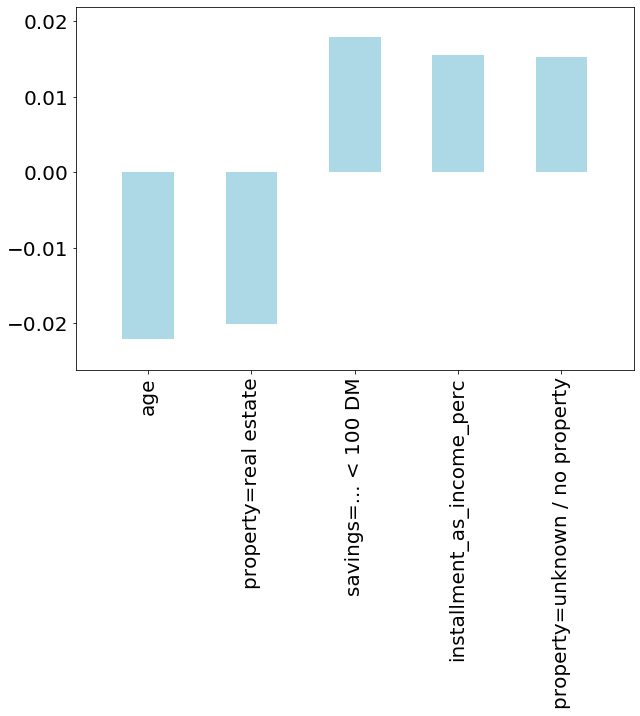

In [ ]:
limeExplainer.plot_lime_values(lime_exp.as_list(), 5, 10)